# ДОМАШНЕЕ ЗАДАНИЕ 3. Классификация текстовых документов
## Цель работы

Приобрести опыт решения практических задач по машинному обучению, таких как анализ и визуализация исходных данных, обучение, выбор и оценка качества моделей предсказания, посредством языка программирования Python.

## Библиотеки

In [1]:
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    HashingVectorizer,
    TfidfTransformer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Выключаем ворнинги, чтобы не засорять вывод при обучении логистической регрессии
# с неоптиимальными параметрами (при GridSearchCV такое будет)
warnings.filterwarnings('ignore')

# Фиксируем RANDOM_STATE как константу для воспроизводимости результатов
RANDOM_STATE = 123

## Вариант

In [2]:
surname = "Панфилкин" # Ваша фамилия

alp = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
w = [4, 42, 21, 21, 34,  1, 44, 26, 18, 43, 38, 26, 18, 43,  3, 49, 45,
        7, 42, 25,  4,  9, 36, 33, 31, 29,  5, 31,  4, 19, 24, 27, 33]
d = dict(zip(alp, w))
variant =  sum([d[el] for el in surname.lower()]) % 3 + 1
print("Ваш вариант - ", variant)

Ваш вариант -  3


### Задание 1. Оценка качества классификации текстовых данных (2 балла)

#### Загрузка данных

In [3]:
# Загрузка данных из файла data/reviews.tsv (первый столбец - метки классов, второй - тексты)
data = pd.read_csv('data/reviews.tsv', sep='\t', names=['target', 'text'])
# Вытащим X и y из датафрейма
X, y = data['text'], data['target']
# Выведем количество наблюдений в каждом классе
for target in y.unique():
    print(f'Класс {target}: {len(y[y == target])} наблюдений')
# Отобразим датафрейм с данными
data

Класс 0: 5331 наблюдений
Класс 1: 5331 наблюдений


,target,text
0,0,unless bob crane is someone of particular inte...
1,1,"finds a way to tell a simple story , perhaps t..."
2,0,"ill-considered , unholy hokum ."
3,0,"nijinsky says , 'i know how to suffer' and if ..."
4,1,the auteur's ear for the way fears and slights...
...,...,...
10657,0,"it's mildly sentimental , unabashedly consumer..."
10658,0,so verbally flatfooted and so emotionally pred...
10659,0,alternative medicine obviously has its merits ...
10660,0,a by-the-numbers patient/doctor pic that cover...


#### Разделение данных

In [4]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=RANDOM_STATE,
)

# Также определим KFold для дальнейшей кросс-валидации (везде будем использовать данный объект)
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

#### Определение функций

In [5]:
def get_metrics(pipeline, X_train, y_train, X_test, y_test):
    """
    Функция для расчета метрик в виде словоря
    """
    # Раскроем пайплайн и отдельно обучим векторайзер, чтобы время обучения векторайзера
    # не учитывалось в метриках
    vectorizer = pipeline['vectorizer']
    classifier = pipeline['classifier']

    # Векторизуем
    X_train_ = vectorizer.fit_transform(X_train)
    X_test_ = vectorizer.transform(X_test)

    # Обучаем
    start = time.time()
    classifier.fit(X_train_, y_train)
    fit_time = time.time() - start

    # Предсказываем
    start = time.time()
    y_pred = classifier.predict(X_test_)
    predict_time = time.time() - start

    # Возвращаем все метрики 
    return {
        'fit_time': fit_time,
        'score_time': predict_time,
        'test_balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred)
    }

def cross_validate(pipeline, X, y, kf):
    """
    Функция для расчета метрик в виде словоря для кросс валидации
    """
    # Тут будем хранить результаты метрик по фолдам
    metrics_list = []
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        metrics_list.append(get_metrics(pipeline, X_train, y_train, X_test, y_test))
    # Через pandas усредним и приведем в одинаковый с get_metrics() вид
    return pd.DataFrame(metrics_list).mean().to_dict()

#### Определение моделей

In [6]:
# Для моделей определим векторайзер TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 1), lowercase=True)
# Для модели Бернулли используем бинарный векторайзер
vectorizer_binary = CountVectorizer(binary=True, ngram_range=(1, 1), lowercase=True)

# Определим пайплайны
pipelines = {
    "К-ближайших соседей": Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "Логистическая регрессия": Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', LogisticRegression(
            penalty='l2',
            fit_intercept=True,
            max_iter=100,
            C=1,
            solver='lbfgs',
            random_state=RANDOM_STATE
        ))
    ]),
    "Наивный Байес: модель Бернулли": Pipeline([
        ('vectorizer', vectorizer_binary),
        ('classifier', BernoulliNB(alpha=1))
    ]),
    "Наивный Байес: полиномиальная модель": Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', MultinomialNB(alpha=1))
    ])
}
# Для единства храним значения параметров (которые в последствии будем менять)
param_names = ["classifier__n_neighbors", "classifier__C", "classifier__alpha", "classifier__alpha"]
# И их значеня (можно было бы вытащить по имени, но так просто проще сейчас сделать)
param_values = [5, 1, 1, 1]

#### Оценка моделей по отложенной выборке

In [7]:
# Словарь с метриками
metrics_dict = {}
# Для каждого метода
for i, (method_name, pipeline) in enumerate(pipelines.items()):
    # Смотрим имя и значения параметров для создания подписи
    param_name = param_names[i]
    param_value = param_values[i]
    label = f"{method_name} ({param_name}={param_value})"

    metrics_dict[label] = get_metrics(pipeline, X_train, y_train, X_test, y_test)

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

,fit_time,score_time,test_balanced_accuracy,test_recall,test_precision,test_f1
К-ближайших соседей (classifier__n_neighbors=5),0.002000,1.262186,0.724304,0.744382,0.716216,0.730028
Логистическая регрессия (classifier__C=1),0.114589,0.000000,0.770246,0.792135,0.759425,0.775435
Наивный Байес: модель Бернулли (classifier__alpha=1),0.006981,0.001000,0.782477,0.774345,0.787619,0.780925
Наивный Байес: полиномиальная модель (classifier__alpha=1),0.003000,0.000000,0.787158,0.784644,0.789077,0.786854


### Задание 2. Оценка качества классификации текстовых данных посредством кросс-валидации (2 балла)

In [8]:
# Словарь с метриками
metrics_dict = {}
# Для каждого метода
for i, (method_name, pipeline) in enumerate(pipelines.items()):
    # Смотрим имя и значения параметров для создания подписи
    param_name = param_names[i]
    param_value = param_values[i]
    label = f"{method_name} ({param_name}={param_value})"
    
    metrics_dict[label] = cross_validate(pipeline, X, y, skf)

metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

,fit_time,score_time,test_balanced_accuracy,test_recall,test_precision,test_f1
К-ближайших соседей (classifier__n_neighbors=5),0.001327,1.308178,0.705873,0.722191,0.699445,0.710574
Логистическая регрессия (classifier__C=1),0.113422,0.000000,0.757177,0.765523,0.753091,0.759204
Наивный Байес: модель Бернулли (classifier__alpha=1),0.003493,0.001010,0.772935,0.763837,0.778135,0.770838
Наивный Байес: полиномиальная модель (classifier__alpha=1),0.002996,0.000250,0.775372,0.769464,0.778748,0.774011


### Задание 3. Выбор модели (4 баллов)

#### Определение функций

In [9]:
def get_validation_scores(
        pipelines: dict, # Словарь с пайплайнами {название метода: пайплайн}
        param_names: list, # Список с названиями параметров (размер как pipelines)
        param_values_list: list, # Список со списками значений параметров (размер как pipelines)
        X, # Данные для обучения
        y, # Целевая переменная
        kf # Стратегия кросс валидации
    ):
    '''
    Функция для расчета метрик поиска по сетке в виде словоря используя кросс валидацию.
    '''
    # Словарь для хранения результатов
    validation_scores = {}
    # Для каждого метода
    for i, (method_name, pipeline) in enumerate(pipelines.items()):
        print(f"Поиск лучшего значения гиперпараметра для модели '{method_name}'...")
        # Определяем параметры для поиска по сетке
        gs = GridSearchCV(
            pipeline,
            param_grid={f"{param_names[i]}": param_values_list[i]},
            scoring='balanced_accuracy',
            cv=kf,
            refit=False, # Не обучаем модель на всех данных в конце (Экономим время)
            return_train_score=True, # Возвращаем значения метрики на обучающей выборке
        )
        # Обучаем модель
        gs.fit(X, y)
        # Вытаскиваем нужные нам метрики и сохраняем в словарь
        validation_scores[method_name] = {
            'train_score': gs.cv_results_['mean_train_score'],
            'test_score': gs.cv_results_['mean_test_score'],
            'fit_time': gs.cv_results_['mean_fit_time'],
            'score_time': gs.cv_results_['mean_score_time'],
            'best_param_index': gs.best_index_
        }
    return validation_scores

def plot_validation_scores(
        validation_scores: dict, # Словарь с метриками из get_validation_scores()
        score_keys: list, # Список с ключами метрик для отрисовки
        score_labels: list, # Список с подписями метрик для отрисовки
        highlight_key: str | None, # Ключ метрики для подсветки лучшего значения
        param_names: list, # Список с названиями параметров (размер как pipelines)
        param_values_list: list, # Список со списками значений параметров (размер как pipelines)
        xscales: list, # Список с типами шкал для оси X (линейная или логарифмическая)
        title: str # Значение ngram_range для отрисовки в заголовке
    ):
    '''
    Функция для визуализации результатов поиска по сетке.
    '''
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for i, (ax, method_name) in enumerate(zip(axes, validation_scores)):
        scores = validation_scores[method_name]
        for score_key, score_label in zip(score_keys, score_labels):
            ax.plot(param_values_list[i], scores[score_key], label=score_label, marker='o')

        if highlight_key is not None:
            # Определение лучшего значения гиперпараметра
            best_param_index = validation_scores[method_name]['best_param_index']
            best_param = param_values_list[i][best_param_index]
            best_accuracy = validation_scores[method_name]['test_score'][best_param_index]
            # Отметим точку с лучшим значением на графике
            ax.scatter(best_param, best_accuracy, marker='o', color='black', zorder=3)
            # Добавим подпись
            ax.annotate(
                f"Top Result:\n({best_param:.2f}, {best_accuracy:.2f})",
                xy=(best_param, best_accuracy),
                xytext=(best_param, best_accuracy - 0.02),
                horizontalalignment='center',
                verticalalignment='top'
            )

        ax.set_title(method_name)
        ax.set_xlabel(param_names[i])
        ax.set_ylabel('Сбалансированная точность')
        ax.set_xscale(xscales[i])
        ax.legend()

    # Фиксим пересечение подписей
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def set_best_params(
        pipelines, # Словарь с пайплайнами {название метода: пайплайн}
        param_names, # Список с названиями параметров (размер как pipelines)
        param_values_list, # Список со списками значений параметров (размер как pipelines)
        validation_scores # Словарь с метриками из get_validation_scores()
    ):
    '''
    Функция для установки лучших значений параметров для моделей.
    '''
    for i, (method_name, pipeline) in enumerate(pipelines.items()):
        best_param_index = validation_scores[method_name]['best_param_index']
        best_param = param_values_list[i][best_param_index]
        pipeline.set_params(**{f'{param_names[i]}': best_param})

#### Подготовка к оценке

In [10]:
# Определим диапазоны значений гиперпараметров
param_values_list = [
    np.arange(1, 150, 20),
    np.logspace(-2, 10, 8, base=10),
    np.logspace(-4, 1, 8, base=10),
    np.logspace(-4, 1, 8, base=10)
]

# Список всех метрик лучгих моделей при каждом значении n-грамм
metrics_list = []
# Список оценок качества моделей при каждом значении n-грамм
# мы сохраним эти данные, чтобы потом выставлять параметры лучших моделей для нужного n-gram
validation_scores = {}

#### ngram=(1, 1)

In [11]:
ngram = (1, 1)
# У векторизатора уже и так стоит ngram_range=(1, 1), но мы явно укажем его для единообразия
vectorizer.set_params(ngram_range=ngram)
vectorizer_binary.set_params(ngram_range=ngram)
# Прогоним все модели для сетки параметров и сохраним результаты для текущего n-грамма
validation_scores[ngram] = get_validation_scores(
    pipelines,
    param_names,
    param_values_list,
    X_train,
    y_train,
    skf
)

Поиск лучшего значения гиперпараметра для модели 'К-ближайших соседей'...
Поиск лучшего значения гиперпараметра для модели 'Логистическая регрессия'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: модель Бернулли'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: полиномиальная модель'...


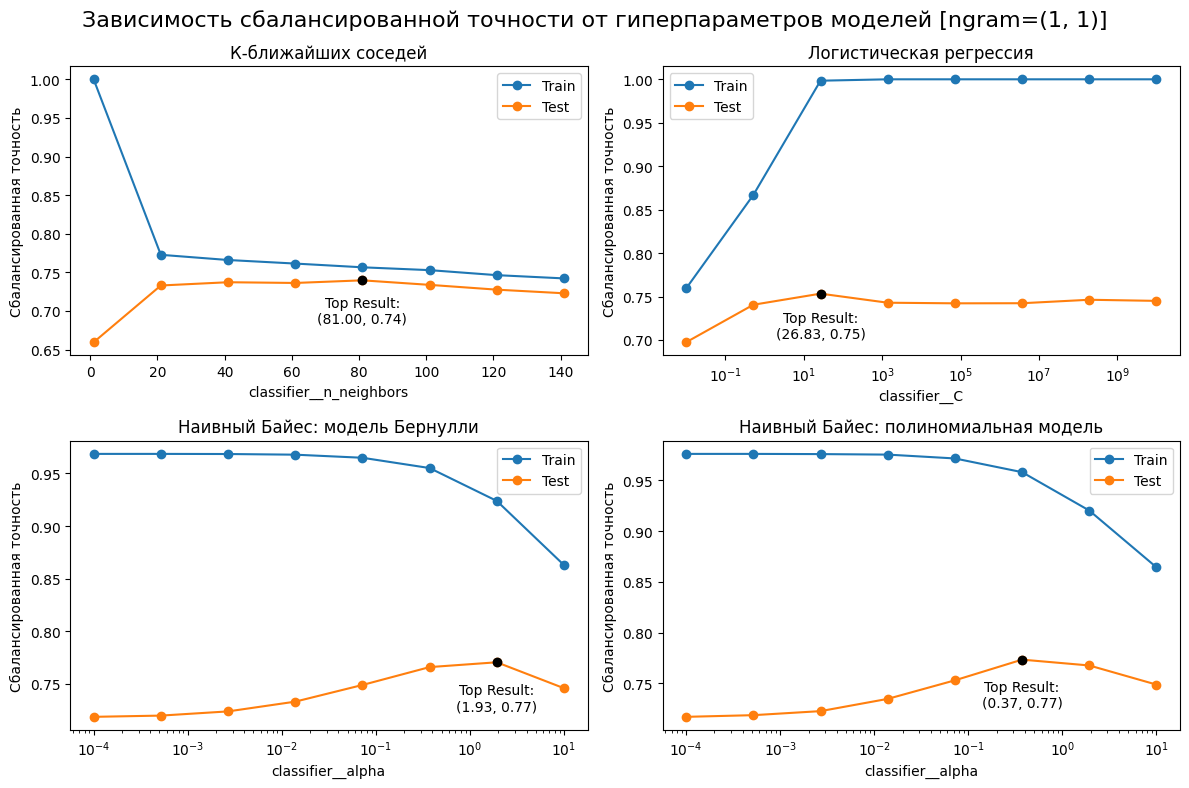

In [12]:
# Построим графики
plot_validation_scores(
    validation_scores=validation_scores[ngram],
    score_keys=['train_score', 'test_score'],
    score_labels=['Train', 'Test'],
    highlight_key='test_score',
    param_names=param_names,
    param_values_list=param_values_list,
    xscales=['linear', 'log', 'log', 'log'],
    title=f'Зависимость сбалансированной точности от гиперпараметров моделей [ngram={ngram}]'
)

In [13]:
# Установим лучшие параметры для каждой модели
set_best_params(pipelines, param_names, param_values_list, validation_scores[ngram])
# Для каждой модели (уже с лучшими параметрами) посчитаем метрики
for i, (method_name, pipeline) in enumerate(pipelines.items()):
    # Получим название параметра и его значение для того, чтобы записать в таблицу
    param_name = param_names[i]
    best_param_index = validation_scores[ngram][method_name]['best_param_index']
    best_param = param_values_list[i][best_param_index]
    # Посчитаем метрики
    # metrics = cross_validate(pipeline, X, y, skf)
    metrics = get_metrics(pipeline, X_train, y_train, X_test, y_test)
    # Добавим к метрикам название метода, название параметра и его значение
    metrics = {
        'method': method_name,
        'ngram': str(ngram),
        'param': f"{param_name}={round(best_param, 2)}",
        **metrics
    }
    metrics_list.append(metrics)

#### ngram=(2, 2)

In [14]:
# Все аналогично для ngram=(1, 1)
ngram = (2, 2)
vectorizer.set_params(ngram_range=ngram)
vectorizer_binary.set_params(ngram_range=ngram)
validation_scores[ngram] = get_validation_scores(
    pipelines,
    param_names,
    param_values_list,
    X_train,
    y_train,
    skf
)

Поиск лучшего значения гиперпараметра для модели 'К-ближайших соседей'...
Поиск лучшего значения гиперпараметра для модели 'Логистическая регрессия'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: модель Бернулли'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: полиномиальная модель'...


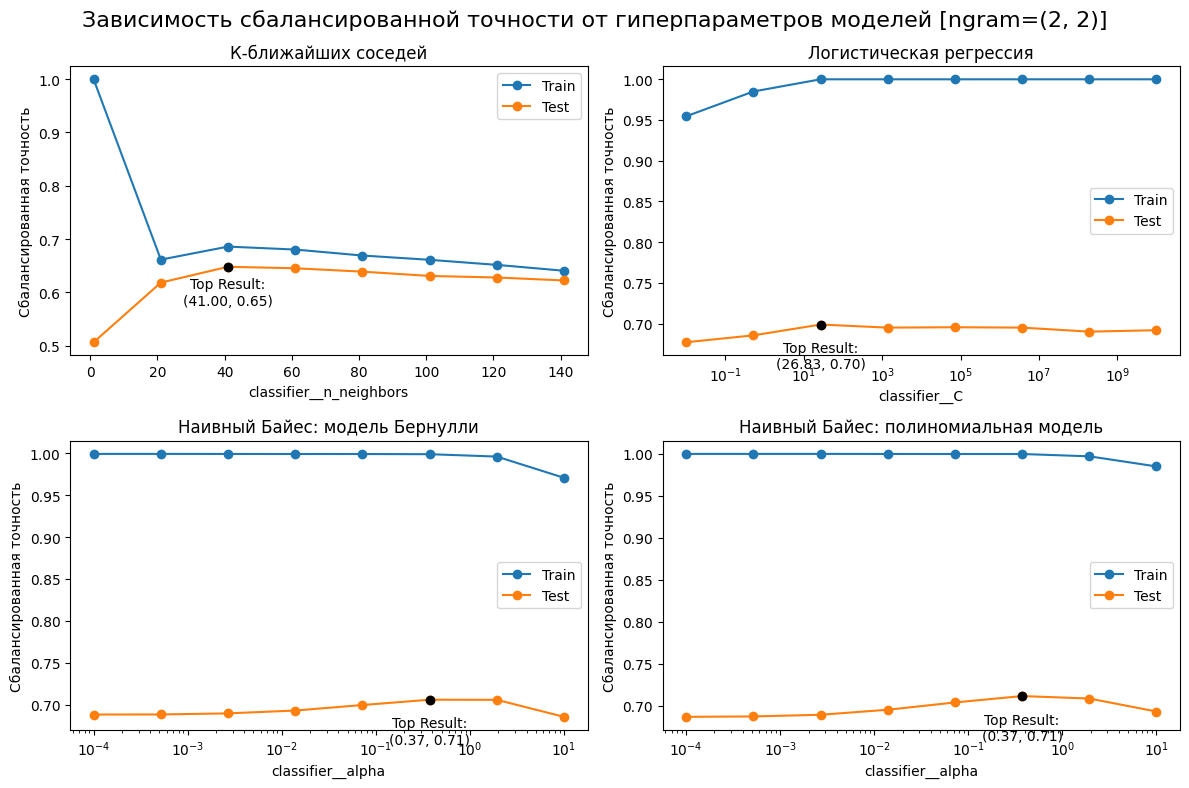

In [15]:
plot_validation_scores(
    validation_scores=validation_scores[ngram],
    score_keys=['train_score', 'test_score'],
    score_labels=['Train', 'Test'],
    highlight_key='test_score',
    param_names=param_names,
    param_values_list=param_values_list,
    xscales=['linear', 'log', 'log', 'log'],
    title=f'Зависимость сбалансированной точности от гиперпараметров моделей [ngram={ngram}]'
)

In [16]:
set_best_params(pipelines, param_names, param_values_list, validation_scores[ngram])
for i, (method_name, pipeline) in enumerate(pipelines.items()):
    param_name = param_names[i]
    best_param_index = validation_scores[ngram][method_name]['best_param_index']
    best_param = param_values_list[i][best_param_index]
    # metrics = cross_validate(pipeline, X, y, skf)
    metrics = get_metrics(pipeline, X_train, y_train, X_test, y_test)
    metrics = {
        'method': method_name,
        'ngram': str(ngram),
        'param': f"{param_name}={round(best_param, 2)}",
        **metrics
    }
    metrics_list.append(metrics)

#### ngram=(1, 2)

In [17]:
# Все аналогично для ngram=(1, 1) и ngram=(2, 2)
ngram = (1, 2)
vectorizer.set_params(ngram_range=ngram)
vectorizer_binary.set_params(ngram_range=ngram)
validation_scores[ngram] = get_validation_scores(
    pipelines,
    param_names,
    param_values_list,
    X_train,
    y_train,
    skf
)

Поиск лучшего значения гиперпараметра для модели 'К-ближайших соседей'...
Поиск лучшего значения гиперпараметра для модели 'Логистическая регрессия'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: модель Бернулли'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: полиномиальная модель'...


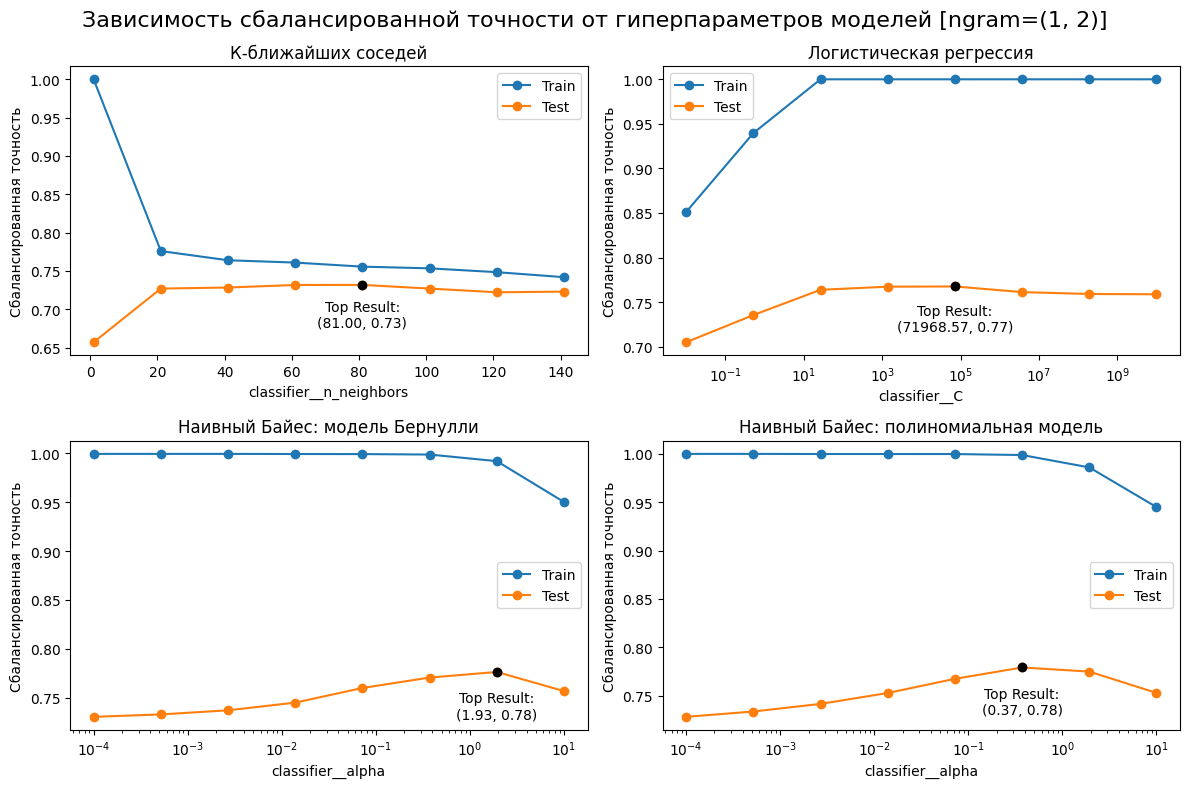

In [18]:
plot_validation_scores(
    validation_scores=validation_scores[ngram],
    score_keys=['train_score', 'test_score'],
    score_labels=['Train', 'Test'],
    highlight_key='test_score',
    param_names=param_names,
    param_values_list=param_values_list,
    xscales=['linear', 'log', 'log', 'log'],
    title=f'Зависимость сбалансированной точности от гиперпараметров моделей [ngram={ngram}]'
)

In [19]:
set_best_params(pipelines, param_names, param_values_list, validation_scores[ngram])
for i, (method_name, pipeline) in enumerate(pipelines.items()):
    param_name = param_names[i]
    best_param_index = validation_scores[ngram][method_name]['best_param_index']
    best_param = param_values_list[i][best_param_index]
    # metrics = cross_validate(pipeline, X, y, skf)
    metrics = get_metrics(pipeline, X_train, y_train, X_test, y_test)
    metrics = {
        'method': method_name,
        'ngram': str(ngram),
        'param': f"{param_name}={round(best_param, 2)}",
        **metrics
    }
    metrics_list.append(metrics)

#### Результаты

In [20]:
# Сохраним метрики в датафрейм и отобразим как таблицу
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,method,ngram,param,fit_time,score_time,test_balanced_accuracy,test_recall,test_precision,test_f1
0,К-ближайших соседей,"(1, 1)",classifier__n_neighbors=81,0.002000,1.237915,0.756635,0.789326,0.741425,0.764626
1,Логистическая регрессия,"(1, 1)",classifier__C=26.83,0.560251,0.000000,0.767923,0.774345,0.765032,0.769660
2,Наивный Байес: модель Бернулли,"(1, 1)",classifier__alpha=1.93,0.003001,0.001986,0.782942,0.778090,0.786187,0.782118
3,Наивный Байес: полиномиальная модель,"(1, 1)",classifier__alpha=0.37,0.003306,0.000000,0.776379,0.770599,0.780095,0.775318
4,К-ближайших соседей,"(2, 2)",classifier__n_neighbors=41,0.002000,0.617793,0.657616,0.426030,0.794066,0.554540
5,Логистическая регрессия,"(2, 2)",classifier__C=26.83,1.300426,0.000995,0.714932,0.731273,0.708711,0.719816
6,Наивный Байес: модель Бернулли,"(2, 2)",classifier__alpha=0.37,0.007000,0.005002,0.717763,0.721910,0.716543,0.719216
7,Наивный Байес: полиномиальная модель,"(2, 2)",classifier__alpha=0.37,0.005637,0.000991,0.728548,0.731273,0.727866,0.729566
8,К-ближайших соседей,"(1, 2)",classifier__n_neighbors=81,0.001995,2.634805,0.759494,0.759363,0.760075,0.759719
9,Логистическая регрессия,"(1, 2)",classifier__C=71968.57,1.900666,0.000000,0.797427,0.826779,0.781416,0.803458


#### Выводы:

!!! Замечание по метрикам: полнота, точность и F1-мера отличаются, в зависимости от того,
какой класс мы считаем положительным. Это может быть важно в задачах, где вероятность ошибки
первого и второго рода имеют разную цену. В нашем случае, мы считаем вероятности ошибок одинаковыми,
поэтому в принципе без разницы, какой класс мы считаем положительным, а какой отрицательным. Плюсом
на паре было сказано, что главное просто показать что вот указанные метрики присутствуют 😎

1. Вывод по методом классификации:
- К-ближайших соседей: данный метод отличается от других тем, что он не требует обучения, а просто
запоминает все данные - это очень быстрый метод, но он не подходит для больших объемов данных, так
как требует много памяти. Также данный метод не подходит для несбалансированных данных, так как он
не учитывает веса классов. При этом время предсказания у него самое большое - так как он считает
расстояние до всех точек каждый раз при предсказании. В принципе данный метод показал себя хуже
всех остальных в задаче классификации текстов.
- Логистическая регрессия: данный метод показал себя лучше чем К-ближайших соседей, но хуже чем
наивный Байес. Он требует некоторого времени на обучение, но при этом время предсказания у него
можно сказать нулевое, так как он просто считает скалярное произведение вектора признаков на вектор
весов. В задачи классификации текстов данный метод занимает место посередине, и лично для меня
является самым универсальным методом классификации для любых данных. По полноте кстати он показал
себя лучше всех остальных методов, но при этом точность и F1-мера у него хуже, чем у наивного Байеса.
- Наивный Байес: оба метода наивного Байеса показали себя лучше всех остальных методов. При этом
данный метод отлично подходит для классификации текстов, так как он имеет вероятностную
интерпретацию, что позволяет справляться с отсутствующими признаками.

Итого, лучшие результаты среди методов классификации показала модель наивного Байеса с полиномиальной
моделью. При этом, если сравнивать модели наивного Байеса, то модель Бернулли показала себя чуть
хуже, чем полиномиальная модель, но все равно лучше, чем остальные методы классификации.

2. Вывод по n-граммам:
- n-граммы (1, 1): в данном случае мы рассматриваем каждое слово как отдельный признак, поэтому
получается большое количество признаков, что приводит к переобучению модели. При этом, если
сравнивать с другими n-граммами, то данная модель показала себя средне.
- n-граммы (2, 2): в данном случае мы рассматриваем каждую пару слов как отдельный признак, поэтому
получается меньшее количество признаков, чем в случае с n-граммами (1, 1). При этом, если сравнивать
с другими n-граммами, то данная модель показала себя хуже всех остальных.
- n-граммы (1, 2): в данном случае мы рассматриваем каждое слово и каждую пару слов как отдельный
признак, поэтому получается большое количество признаков. При этом, если сравнивать с другими
n-граммами, то данная модель показала себя лучше всех остальных. Так как учитываются и отдельные
слова, и пары слов.

Если рассматривать время обучения и предсказания, то логично предположить, что чем больше получается
признаков, тем больше времени занимает обучение и предсказание. Также, чем больше признаков, тем
больше памяти требуется для хранения данных. Поэтому, если рассматривать время обучения и
предсказания, то лучше всего использовать n-граммы (1, 1), так как в данном случае получается
среднее количество признаков, но и средние показатели качества. Если рассматривать только качество,
то лучше всего использовать n-граммы (1, 2).

### Задание 4. Оценка влияния количества признаков FeatureHasher на качество классификации

In [21]:
# Определим новые элементы пайплайна
# HashingVectorizer используется для векторизации текста. Его преимущество в том, что он не хранит 
# словарь в памяти, а использует хэш-функцию для преобразования слов в индексы. Это позволяет
# снизить потребление памяти и ускорить процесс векторизации.
hashing_vectorizer = HashingVectorizer(norm=None, alternate_sign=False)
# TfidfTransformer используется для преобразования векторов, полученных с помощью HashingVectorizer,
# в вектора с tf-idf весами.
tfidf_transformer = TfidfTransformer(norm=None)

# Новые пайплайны! Все аналогично, но перед классификатором стоит сначала HashingVectorizer, а затем
# TfidfTransformer - ровно по заданию
pipelines_hashing = {
    'К-ближайших соседей': Pipeline([
        ('vectorizer', hashing_vectorizer),
        ('transformer', tfidf_transformer),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Логистическая регрессия': Pipeline([
        ('vectorizer', hashing_vectorizer),
        ('transformer', tfidf_transformer),
        ('classifier', LogisticRegression(
            penalty='l2',
            fit_intercept=True,
            max_iter=100,
            C=1,
            solver='lbfgs',
            random_state=RANDOM_STATE
        ))
    ]),
    "Наивный Байес: модель Бернулли": Pipeline([
        ('vectorizer', hashing_vectorizer),
        # В модели Бернулли не нужен TfidfTransformer, так как используются бинарные признаки,
        # полученные с помощью HashingVectorizer
        ('classifier', BernoulliNB(alpha=1.0))
    ]),
    "Наивный Байес: полиномиальная модель": Pipeline([
        ('vectorizer', hashing_vectorizer),
        ('transformer', tfidf_transformer),
        ('classifier', MultinomialNB(alpha=1.0))
    ])
}

# Установим лучшие параметры при ngram=(1, 1)
ngram = (1, 1)
set_best_params(pipelines_hashing, param_names, param_values_list, validation_scores[ngram])

In [22]:
# Название параметра для оценки по сетке - 'vectorizer__n_features' для всех моделей
param_names_hashing = ['vectorizer__n_features']*4
# Значения параметров для оценки по сетке одинаковые для всех моделей
param_values_list_hashing = [np.logspace(1, 5, 5, base=10, dtype=int)]*4

In [23]:
# Вычислим метрики для всех новых моделей при ngram=(1, 1)
validation_scores_hashing = get_validation_scores(
    pipelines_hashing,
    param_names_hashing,
    param_values_list_hashing,
    X_train,
    y_train,
    skf
)

Поиск лучшего значения гиперпараметра для модели 'К-ближайших соседей'...
Поиск лучшего значения гиперпараметра для модели 'Логистическая регрессия'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: модель Бернулли'...
Поиск лучшего значения гиперпараметра для модели 'Наивный Байес: полиномиальная модель'...


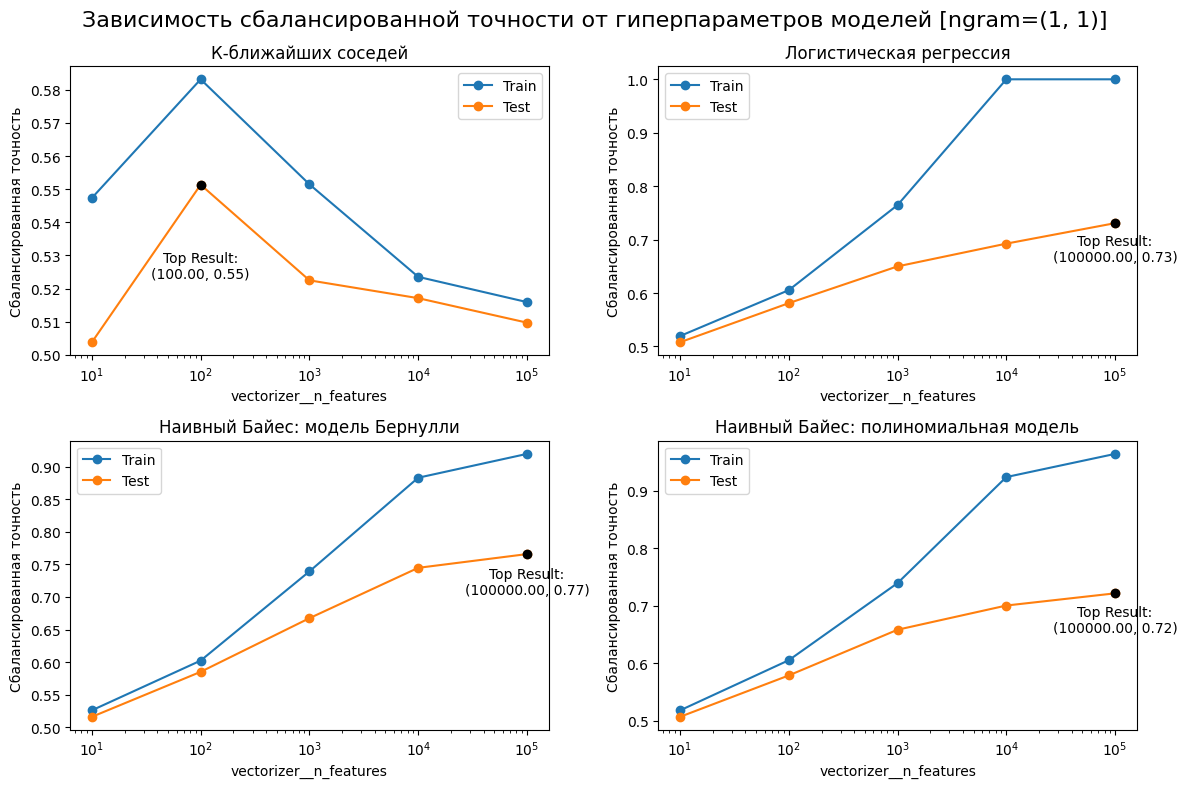

In [24]:
# Построим график зависимости сбалансированной точности от гиперпараметров моделей
plot_validation_scores(
    validation_scores=validation_scores_hashing,
    score_keys=['train_score', 'test_score'],
    score_labels=['Train', 'Test'],
    highlight_key='test_score',
    param_names=param_names_hashing,
    param_values_list=param_values_list_hashing,
    xscales=['log']*4,
    title=f'Зависимость сбалансированной точности от гиперпараметров моделей [ngram={ngram}]'
)

#### Выводы

Влияние увеличения числа признаков HashingVectorizer на качество предсказания:
- К-ближайших соседей: увеличение числа признаков приведет сначала к легкому увеличению качества, однако далее наблюдается - достаточно сильный спад точности. По сравнению с обычным TfidfVectorizer, качество заметно хуже.
- Логистическая регрессия: увеличение числа признаков приводит к увеличению качества предсказания. По сравнению с обычным TfidfVectorizer, качество заметно хуже.
- Наивный Байес: модель Бернулли: увеличение числа признаков приводит к увеличению качества предсказания. По сравнению с обычным CountVectorizer, лучшее полученное качество практически не отличается.
- Наивный Байес: полиномиальная модель: увеличение числа признаков приводит к увеличению качества предсказания. По сравнению с обычным TfidfVectorizer, качество немного хуже.

В модели К-ближайших соседей увеличение числа признаков приводит к увеличению размерности пространства признаков, что приводит к увеличению количества соседей, которые находятся на одинаковом расстоянии от объекта. Это приводит к увеличению количества ошибок при классификации.
В других моделях увеличение числа признаков приводит к увеличению размерности пространства признаков, что приводит к увеличению количества линейно независимых признаков. Это приводит к увеличению качества предсказания.